In [16]:
from term_grouping import *
from print_cliques import print_cliques
import matplotlib.pyplot as plt
from collections import Counter
import time
import numpy as np
import glob
from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, get_interaction_operator
#from openfermionpsi4 import run_psi4
from openfermion.transforms import (jordan_wigner, bravyi_kitaev, bravyi_kitaev_fast, bravyi_kitaev_tree,
                                    binary_code_transform, reverse_jordan_wigner)
from openfermion.utils import group_into_tensor_product_basis_sets
from openfermion.transforms._binary_codes import parity_code
from scipy.optimize import curve_fit

plt.rcParams["font.size"] = 13
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["font.family"] = 'STIXGeneral'
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

### Generate benchmark hamiltonians for the OpenFermion algorithm
OpenFermion's minclique cover takes a QubitHamiltonian as input so these need to be generated 
separately from the hamiltonians in the the hamiltonians/ directory.

In [2]:
def load_transform_group(filename, encoding_AS_dict):
    # Load molecule from file
    print('--- loading molecule ---')
    molecule = MolecularData(filename=filename)
    print('filename: {}'.format(molecule.filename))
    print('--- compute integrals ---')
    molecule = run_psi4(molecule,run_mp2=True,run_cisd=True,run_ccsd=True,run_fci=True)
    
    #print(molecule.two_body_integrals)
    #print(molecule.canonical_orbitals)
    #print('n_atoms: {}'.format(molecule.n_atoms))
    #print('n_electrons: {}'.format(molecule.n_electrons))
    #print('n_orbitals: {}'.format(molecule.n_orbitals))
    #print('Canonical Orbitals: {}'.format(molecule.canonical_orbitals))
    #print('n_qubits: {}'.format(molecule.n_qubits))
    
    # construct Hamiltonian for each pair of transform-AS in encoding_AS_dict
    data = []
    for transform in encoding_AS_dict.keys():
        print('\n>>>> Using {} transform'.format(transform))
        all_orbital_pairs = encoding_AS_dict[transform]
        for orbital_pair in all_orbital_pairs:
            
            occupied_num, active_num = orbital_pair
            print('ActiveSpace = {}'.format(active_num))
            
            # Construct Hamiltonian
            molecular_hamiltonian = molecule.get_molecular_hamiltonian(
                                    occupied_indices=range(occupied_num),
                                    active_indices=range(active_num))
    
            # map the operator to fermions and then qubits
            fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
    
            # get interaction operator (needed for BKSF)
            interaction_hamiltonian = get_interaction_operator(fermion_hamiltonian)
    
            if transform is 'JW':
                qubit_h = jordan_wigner(fermion_hamiltonian)
                qubit_h.compress()
            elif transform is 'BK':
                qubit_h = bravyi_kitaev(fermion_hamiltonian)
                qubit_h.compress()
            elif transform is 'BKSF':
                qubit_h = bravyi_kitaev_fast(interaction_hamiltonian)
                qubit_h.compress()
            elif transform is 'BKT':
                qubit_h = bravyi_kitaev_tree(fermion_hamiltonian)
                qubit_h.compress()
            elif transform is 'PC':
                qubit_h = binary_code_transform(fermion_hamiltonian, parity_code(2*active_num))
                qubit_h.compress()
            else:
                print('ERROR: Unrecognized qubit transformation: {}'.format(transform))
                sys.exit(2)
                
            num_terms = len(qubit_h.terms.keys()) - 1
            print('OPENFERMION: generated Hamiltonian with {} terms (excluding Identity)'.format(num_terms))
                
            # Use OpenFermion function to group into commuting sets using QWC
            # time the computation
            start_time = time.time()
            cliques = group_into_tensor_product_basis_sets(qubit_h)
            end_time = time.time()
            
            print('OPENFERMION: group_into_tensor_product_basis_sets found {} unique circuits'.format(len(cliques)))
            et = end_time - start_time
            print('OPENFERMION: Elapsed time: {:.6f}s'.format(et))
            
            data.append((num_terms,len(cliques),et))
            
    return data

In [49]:
ch4filename = 'molecule_data/CH4_sto-3g_singlet_grnd.hdf5'
ch4dict = {'BK': [(9,1),(9,2),(9,3),(9,4),(9,5),(9,6),(9,7),(9,8),(9,9)]}

h2filename1 = 'molecule_data/H2_6-31g_singlet_0.7.hdf5'
h2dict1 = {'BK': [(4,1),(4,2),(4,3),(4,4)],
           'BKSF': [(4,4)], 'BKT': [(4,4)],
           'JW': [(4,1),(4,2),(4,3),(4,4)],
           'PC': [(4,4)]}

h2filename2 = 'molecule_data/H2_sto-3g_singlet_0.7.hdf5'
h2dict2 = {'BK': [(2,1),(2,2)]}

h2ofilename1 = 'molecule_data/H2O_6-31g_singlet_104.hdf5'
h2odict1 = {'BK': [(6,1),(6,2),(6,3),(6,4),(6,5),(6,6)],
           'BKSF': [(6,6)], 'BKT': [(6,6)],
           'JW': [(6,6)],
           'PC': [(6,6)]}

h2ofilename2 = 'molecule_data/H2O_sto-3g_singlet_104.hdf5'
h2odict2 = {'BK': [(6,1),(6,2),(6,3),(6,4),(6,5),(6,6)]}

lihfilename = 'molecule_data/LiH_sto-3g_singlet_1.45.hdf5'
lihdict = {'BK': [(6,1),(6,2),(6,3),(6,4),(6,5),(6,6)]}

filelist = [ch4filename, h2filename1, h2filename2, h2ofilename1, h2ofilename2, lihfilename]
dictlist = [ch4dict,     h2dict1,     h2dict2,     h2odict1,     h2odict2,     lihdict]

all_data = []
for fname, encode_dict in zip(filelist,dictlist):
    cur_data = load_transform_group(fname, encode_dict)
    all_data.append(cur_data)

--- loading molecule ---
filename: molecule_data/CH4_sto-3g_singlet_grnd
--- compute integrals ---

>>>> Using BK transform
ActiveSpace = 1
OPENFERMION: generated Hamiltonian with 3 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 1 unique circuits
OPENFERMION: Elapsed time: 0.001992s
ActiveSpace = 2
OPENFERMION: generated Hamiltonian with 26 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 8 unique circuits
OPENFERMION: Elapsed time: 0.002163s
ActiveSpace = 3
OPENFERMION: generated Hamiltonian with 93 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 33 unique circuits
OPENFERMION: Elapsed time: 0.003411s
ActiveSpace = 4
OPENFERMION: generated Hamiltonian with 240 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 70 unique circuits
OPENFERMION: Elapsed time: 0.010487s
ActiveSpace = 5
OPENFERMION: generated Hamiltonian with 591 terms (excluding Identity)


>>>> Using BK transform
ActiveSpace = 1
OPENFERMION: generated Hamiltonian with 3 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 1 unique circuits
OPENFERMION: Elapsed time: 0.002077s
ActiveSpace = 2
OPENFERMION: generated Hamiltonian with 26 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 8 unique circuits
OPENFERMION: Elapsed time: 0.002313s
ActiveSpace = 3
OPENFERMION: generated Hamiltonian with 117 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 40 unique circuits
OPENFERMION: Elapsed time: 0.004573s
ActiveSpace = 4
OPENFERMION: generated Hamiltonian with 192 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 55 unique circuits
OPENFERMION: Elapsed time: 0.007850s
ActiveSpace = 5
OPENFERMION: generated Hamiltonian with 275 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 65 unique circuits
OPENFERMION: Elapsed t

In [50]:
# write results to file
with open('Data/openfermion_clique_cover_results.txt', 'w') as fn:
    for dset in all_data:
        for run in dset:
            nterms, ncliques, runtime = run
            fn.write('{0} {1} {2:.6f}\n'.format(str(nterms).ljust(5), str(ncliques).ljust(5), runtime))

# Plot benchmarks
Benchmarks are organized:
--------------------------------
0 -> BH_QWC

1 -> BH_FULL

2 -> BK_QWC

3 -> BK_FULL

4 -> OP_QWC


In [17]:
bh_qwc_bmarks_fn = glob.glob('Data/Bopp*QWC*')
bh_full_bmarks_fn = glob.glob('Data/Bopp*FULL*')
bk_qwc_bmarks_fn = glob.glob('Data/Bron*QWC*')
bk_full_bmarks_fn = glob.glob('Data/Bron*FULL*')
op_qwc_bmarks_fn = glob.glob('Data/openfermion*clique*')
bmarks_fn = [bh_qwc_bmarks_fn, bh_full_bmarks_fn, bk_qwc_bmarks_fn, bk_full_bmarks_fn, op_qwc_bmarks_fn]

In [18]:
for bm in bmarks_fn:
    print(bm)

['Data/BoppanaHalldorsson_QWC_5237term_results.txt', 'Data/BoppanaHalldorsson_QWC_1519term_results.txt', 'Data/BoppanaHalldorsson_QWC_1495term_results.txt', 'Data/BoppanaHalldorsson_QWC_1495term_results1.txt', 'Data/BoppanaHalldorsson_QWC_3006term_results.txt', 'Data/BoppanaHalldorsson_QWC_results.txt', 'Data/BoppanaHalldorsson_QWC_8484term_results.txt']
['Data/BoppanaHalldorsson_FULL_results.txt', 'Data/BoppanaHalldorsson_FULL_5237term_results.txt', 'Data/BoppanaHalldorsson_FULL_6term_results.txt', 'Data/BoppanaHalldorsson_FULL_1519term_results.txt', 'Data/BoppanaHalldorsson_FULL_1495term_results.txt', 'Data/BoppanaHalldorsson_FULL_163term_results.txt', 'Data/BoppanaHalldorsson_FULL_100term_results.txt', 'Data/BoppanaHalldorsson_FULL_3006term_results.txt', 'Data/BoppanaHalldorsson_FULL_15term_results.txt', 'Data/BoppanaHalldorsson_FULL_164term_results.txt', 'Data/BoppanaHalldorsson_FULL_5term_results.txt', 'Data/BoppanaHalldorsson_FULL_8484term_results.txt', 'Data/BoppanaHalldorsson_F

In [19]:
bmarks = []
for bm in bmarks_fn:
    first = True
    for fn in bm:
        print(fn)
        if first == True:
            temp_bm = np.array(np.genfromtxt(fn))
            first = False
        else:
            temp_bm = np.vstack((temp_bm,np.genfromtxt(fn)))
    bmarks.append((temp_bm))

Data/BoppanaHalldorsson_QWC_5237term_results.txt
Data/BoppanaHalldorsson_QWC_1519term_results.txt
Data/BoppanaHalldorsson_QWC_1495term_results.txt
Data/BoppanaHalldorsson_QWC_1495term_results1.txt
Data/BoppanaHalldorsson_QWC_3006term_results.txt
Data/BoppanaHalldorsson_QWC_results.txt
Data/BoppanaHalldorsson_QWC_8484term_results.txt
Data/BoppanaHalldorsson_FULL_results.txt
Data/BoppanaHalldorsson_FULL_5237term_results.txt
Data/BoppanaHalldorsson_FULL_6term_results.txt
Data/BoppanaHalldorsson_FULL_1519term_results.txt
Data/BoppanaHalldorsson_FULL_1495term_results.txt
Data/BoppanaHalldorsson_FULL_163term_results.txt
Data/BoppanaHalldorsson_FULL_100term_results.txt
Data/BoppanaHalldorsson_FULL_3006term_results.txt
Data/BoppanaHalldorsson_FULL_15term_results.txt
Data/BoppanaHalldorsson_FULL_164term_results.txt
Data/BoppanaHalldorsson_FULL_5term_results.txt
Data/BoppanaHalldorsson_FULL_8484term_results.txt
Data/BoppanaHalldorsson_FULL_165term_results.txt
Data/BoppanaHalldorsson_FULL_4term_r

In [20]:
print(len(bmarks))

5


In [21]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [22]:
def return_with_errors(xvals, yvals):
    val_dict = {}
    for x1,y1 in zip(xvals, yvals):
        try:
            val_dict[str(x1)].append(y1)
        except KeyError:
            val_dict[str(x1)] = [y1]
            
    real_xvals, real_yvals, min_err, max_err = [], [], [], []
    for k in sorted(val_dict.keys(), key=lambda term: float(term)):
        #print('{}: {}'.format(k,val_dict[k]))
        real_xvals.append(float(k))
        mean = np.mean(val_dict[k])
        real_yvals.append(mean)
        min_err.append(mean - min(val_dict[k]))
        max_err.append(max(val_dict[k]) - mean)
    err = np.stack((min_err,max_err))
    
    return real_xvals, real_yvals, err

In [23]:
def lin_func(x, m):
    return [m * xx for xx in x]

def lin_log_func(x, m, b):
    return [(m * xx) / (b * np.log2(xx)**2) for xx in x]

def quad_func(x, a, b):
    return [a * xx**2 + b * xx for xx in x]

def exp_func(x, a, b, c, d, e):
    return [a * b**(c * xx + d) for xx in x]

In [24]:
def get_clique_fit_func(label):
    if label in ['BK_QWC', 'BK_FULL', 'OP_QWC', 'BH_FULL', 'BH_QWC']:
        return lin_func
    
def get_runtime_fit_func(label):
    if label in ['BH_FULL', 'OP_QWC']:
        return quad_func
    elif label in ['BH_QWC', 'BK_QWC', 'BK_FULL']:
        return exp_func
    if label in ['OP_QWC']:
        return lin_func

PLOTTING: BH_QWC
PLOTTING: BH_FULL
PLOTTING: BK_QWC
PLOTTING: BK_FULL
PLOTTING: OP_QWC


/Users/pranavgokhale/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


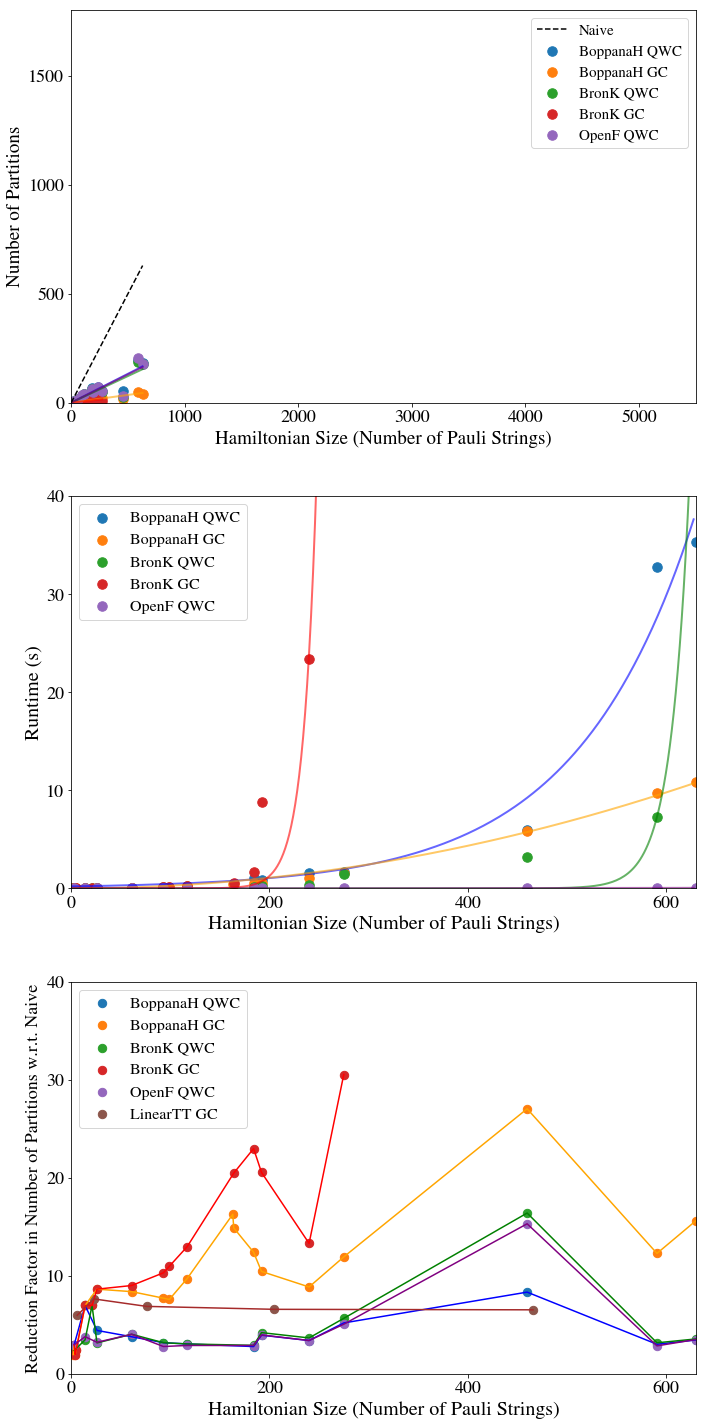

In [28]:
# Same plot but throwing away data for |H| > some_limit
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(10,20))

labels = ['BH_QWC','BH_FULL','BK_QWC','BK_FULL','OP_QWC']
color = ['blue','orange','green','red','purple']
actual_labels = ['BoppanaH QWC', 'BoppanaH GC', 'BronK QWC', 'BronK GC', 'OpenF QWC']

for i, bm in enumerate(bmarks):
    print('PLOTTING: {}'.format(labels[i]))
    #if labels[i] not in ['OP_QWC']:
    #    continue
    terms_temp = bm[:,0]
    cliques_temp = bm[:,1]
    runtime_temp = bm[:,2]
    
    # Sort the benchmarks and get their errors
    terms_temp2, cliques_temp2, clique_err_temp2 = return_with_errors(terms_temp, cliques_temp)
    _, runtime_temp2, runtime_err_temp2 = return_with_errors(terms_temp, runtime_temp)
        
    # truncate the data for |H| > my_limit
    my_limit = 630
    terms, cliques, clique_err, runtime, runtime_err = [], [], [[],[]], [], [[],[]]
    for m in range(len(terms_temp2)):
        if terms_temp2[m] <= my_limit:
            terms.append(terms_temp2[m])
            cliques.append(cliques_temp2[m])
            clique_err[0].append(clique_err_temp2[0][m])
            clique_err[1].append(clique_err_temp2[1][m])
            runtime.append(runtime_temp2[m])
            runtime_err[0].append(runtime_err_temp2[0][m])
            runtime_err[1].append(runtime_err_temp2[1][m])
    
    # compute reduction factors cliques_found / naive
    reduction = [nterm/cliq for cliq, nterm in zip(cliques,terms)]
    
    # print the benchmarks
    #for n in range(len(terms)):
    #    print('{}: {} [{},{}]'.format(terms[n], cliques[n], clique_err[0][n], clique_err[1][n]))
    
    # Fit the benchmarks
    clique_fit_func = get_clique_fit_func(labels[i])
    runtime_fit_func = get_runtime_fit_func(labels[i])
    
    fit_x = np.arange(0,terms[-1],2)
    
    cpopt, cpcov = curve_fit(clique_fit_func, terms, cliques)
    ax[0].plot(fit_x, clique_fit_func(fit_x, *cpopt),c=color[i],ls='-',lw=2,alpha=0.6)
               #label='fit: {:.2f} x + {:.2f}'.format(*cpopt))
    
    if labels[i] in ['BH_FULL']:
        runtime_bounds = [0,1000]
    else:
        runtime_bounds = [-np.inf,np.inf]
    rpopt, rpcov = curve_fit(runtime_fit_func, terms, runtime, bounds=runtime_bounds)
    ax[1].plot(fit_x, runtime_fit_func(fit_x, *rpopt),c=color[i],ls='-',lw=2,alpha=0.6)
               #label='fit: {:.2f} * x**(2) + {:.2f} * x'.format(*rpopt))
    
    # Plot #terms vs #cliques
    #ax[0].errorbar(terms,cliques,yerr=[clique_err[0],clique_err[1]],fmt='o',ms=8,label=actual_labels[i])
    ax[0].scatter(terms,cliques,s=90,label=actual_labels[i])
    
    
    # Plot #terms vs runtime
    #ax[1].errorbar(terms,runtime,yerr=[runtime_err[0],runtime_err[1]],fmt='o',ms=8,label=actual_labels[i])
    ax[1].scatter(terms,runtime,s=90,label=actual_labels[i])
    
    # Plot reduction factor
    ax[2].scatter(terms,reduction,s=70,label=actual_labels[i])
    ax[2].plot(terms,reduction,c=color[i])
    

ax[2].scatter([6.0, 23.0, 76.0, 205.0, 466.0], [6.0, 7.67, 6.91, 6.61, 6.56], s=70,label='LinearTT GC')
ax[2].plot([6.0, 23.0, 76.0, 205.0, 466.0], [6.0, 7.67, 6.91, 6.61, 6.56], c='brown')
    
# plot Naive clique partitioning
ax[0].plot(np.arange(terms[-1]),np.arange(terms[-1]),ls='--',c='k',label='Naive')
# set ax0 settings
ax[0].legend(fontsize=15)
ax[0].set_ylabel('Number of Partitions',fontsize=19)
ax[0].set_xlabel('Hamiltonian Size (Number of Pauli Strings)',fontsize=19)
ax[0].set_xlim(0,5500)
ax[0].set_ylim(0,1800)
ax[0].locator_params(axis='y',tight=True, nbins=6)
ax[0].locator_params(axis='x',tight=True, nbins=6)

# set ax1 settings
#ax[1].set_yscale('log')
ax[1].set_ylabel('Runtime (s)',fontsize=20)
ax[1].set_xlabel('Hamiltonian Size (Number of Pauli Strings)',fontsize=20)
ax[1].legend(fontsize=16)
ax[1].set_xlim(0,630)
ax[1].set_ylim(0,40)
ax[1].locator_params(axis='y',tight=True, nbins=6)
ax[1].locator_params(axis='x',tight=True, nbins=6)

# set ax2 settings
ax[2].set_ylabel('Reduction Factor in Number of Partitions w.r.t. Naive',fontsize=18)
ax[2].set_xlabel('Hamiltonian Size (Number of Pauli Strings)',fontsize=20)
ax[2].legend(loc='upper left',fontsize=16)
ax[2].set_xlim(0,630)
ax[2].set_ylim(0,40)
ax[2].locator_params(axis='y',tight=True, nbins=6)
ax[2].locator_params(axis='x',tight=True, nbins=6)
    
plt.tight_layout()
plt.savefig('Figures/scaling.pdf',format='pdf')

In [22]:
#print(bmarks[3])

bk_terms = bmarks[3][:,0]
bk_times = bmarks[3][:,2]
    
# Fit the benchmarks
runtime_fit_func = get_runtime_fit_func('BK_FULL')

rpopt, rpcov = curve_fit(runtime_fit_func, bk_terms, bk_times)
eqn = '{:.5f} * {:.2f}**({:.2f} * x + {:.2f})'.format(*rpopt)
print(eqn)

0.00317 * 1.02**(3.04 * x + -349.47)
